<a href="https://colab.research.google.com/github/arianajschindler/housing_market_and_covid_cases/blob/main/housing_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Index and COVID-19 Cases Analysis (ongoing, last updated 03/01/2022)

My outcome variable is average US housing index price. I have data that dates back to 2001 for variables such as average housing index, unemployment rate, population, layoffs and discharges, hires, working age population, and initial claims. My covid data includes the variables total cases, median new cases, total covid deaths, median new deaths, positive rate, total vaccinations, and people fully vaccinated.

In [145]:
# mounting the google drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [146]:
# importing data
import pandas as pd
data = pd.read_csv('/gdrive/MyDrive/BioStat/biostat_project_data.csv')
data.head()

,observation_date,avg_us_housing,unemployment_rate,pop_in_thousands,layoffs_and_discharges,hires,total_cases,median_new_cases,total_covid_deaths,median_new_deaths,positive_rate,total_vaccinations,people_fully_vaccinated,working_age_population,initial_claims
0,1/1/2001,135714,4.2,283960,2220,5722,0,0.0,0,0.0,0.0,0,0,180406427.5,353000
1,2/1/2001,136448,4.2,284166,1855,5303,0,0.0,0,0.0,0.0,0,0,180565764.4,340000
2,3/1/2001,137194,4.3,284380,2133,5528,0,0.0,0,0.0,0.0,0,0,180629968.9,370500
3,4/1/2001,137991,4.4,284602,1883,5204,0,0.0,0,0.0,0.0,0,0,180904789.2,388000
4,5/1/2001,138812,4.3,284834,2029,5410,0,0.0,0,0.0,0.0,0,0,181014919.9,399000


In [147]:
# checking the data types of the variables in the dataset
data.dtypes

observation_date            object
avg_us_housing               int64
unemployment_rate          float64
pop_in_thousands             int64
layoffs_and_discharges       int64
hires                        int64
total_cases                  int64
median_new_cases           float64
total_covid_deaths           int64
median_new_deaths          float64
positive_rate              float64
total_vaccinations           int64
people_fully_vaccinated      int64
working_age_population     float64
initial_claims               int64
dtype: object

In [148]:
data.describe()

,avg_us_housing,unemployment_rate,pop_in_thousands,layoffs_and_discharges,hires,total_cases,median_new_cases,total_covid_deaths,median_new_deaths,positive_rate,total_vaccinations,people_fully_vaccinated,working_age_population,initial_claims
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000,252.000000,252.000000,252.000000,2.520000e+02,2.520000e+02,2.520000e+02,2.520000e+02
mean,197834.607143,6.052778,310603.750000,1960.130952,5083.781746,1.849657e+06,6306.045635,33734.936508,108.152778,0.006407,1.293647e+07,5.789993e+06,1.981409e+08,4.001974e+05
std,37096.463360,1.939820,14405.935712,866.202093,671.254469,7.717015e+06,27062.396430,132128.387194,438.311503,0.023993,6.671286e+07,3.039788e+07,7.697316e+06,3.320899e+05
min,135714.000000,3.500000,283960.000000,1169.000000,3639.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.804064e+08,2.100000e+05
25%,170297.500000,4.700000,298115.000000,1775.750000,4620.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.927869e+08,2.900000e+05
50%,191823.500000,5.600000,311974.500000,1882.000000,5137.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.000266e+08,3.465000e+05
75%,216171.750000,7.200000,323729.000000,1991.750000,5460.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.052588e+08,4.091250e+05
max,320662.000000,14.700000,331895.000000,13046.000000,8272.000000,4.871933e+07,219577.000000,783743.000000,3577.000000,0.195500,4.721985e+08,2.000267e+08,2.067926e+08,4.535500e+06


In [149]:
# creating a datetime data type for the observation date variable
data['datetime'] = pd.to_datetime(data['observation_date'])

## EDA

In [150]:
# creating a heatmap of all of the variables
correlation = data.corr()

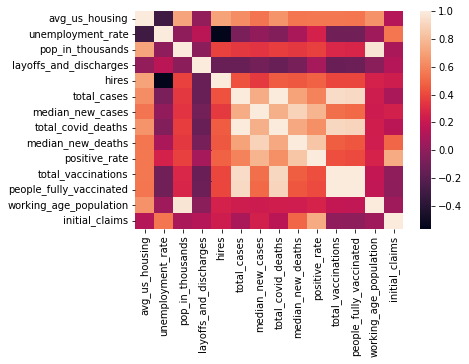

In [151]:
# heatmap
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


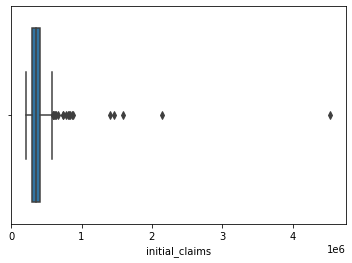

In [152]:
import seaborn as sns
sns.boxplot(data['initial_claims'])

I am going to create a new variable to indicate whether covid cases were being recorded at the time of any relationship I explore.

In [153]:
#a function that creates a binary dummy variable based on the covid variable 
def clean(row):
    if row['total_cases'] == 0:
        val = 0
    else:
        val = 1
    return val

#adds a new row 
data['covid_bool'] = data.apply(clean, axis=1)

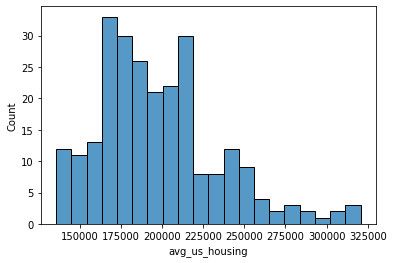

In [154]:
sns.histplot(data['avg_us_housing'], bins=20)

In [155]:
import numpy as np

Text(0.5, 1.0, 'Hires by Covid Bool')

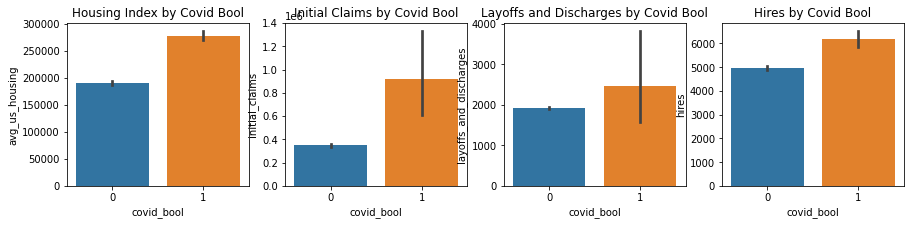

In [156]:
# checking the average housing index, initial claims, layoffs and discharges,
# and hires against the covid boolean

fig, axes = plt.subplots(1, 4, sharex=True, figsize=(15,3))
sns.barplot(ax=axes[0], x=data['covid_bool'], y=data['avg_us_housing'])
axes[0].set_title('Housing Index by Covid Bool')

sns.barplot(ax=axes[1], x=data['covid_bool'], y=data['initial_claims'])
axes[1].set_title('Initial Claims by Covid Bool')

sns.barplot(ax=axes[2], x=data['covid_bool'], y=data['layoffs_and_discharges'])
axes[2].set_title('Layoffs and Discharges by Covid Bool')

sns.barplot(ax=axes[3], x=data['covid_bool'], y=data['hires'])
axes[3].set_title('Hires by Covid Bool')

## Relationship between ave_us_housing and median_new_cases

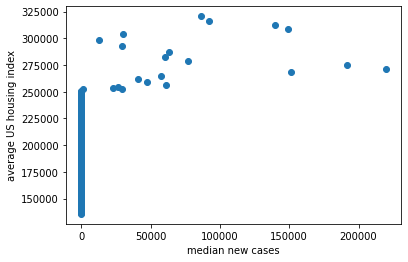

In [157]:
# visualizing the relationship between the average housing index and median new covid cases
import matplotlib.pyplot as plt

plt.scatter(y=data['avg_us_housing'], x=data['median_new_cases'])
plt.xlabel('median new cases')
plt.ylabel('average US housing index')
plt.show()

As seen in the scatterplot above, our data being split between all zeros for covid variables for the first ~18 years of our dataset is going to affect the accuracy of any correlation we run.

In [158]:
# correlation between average housing index and median new cases
from scipy import stats
y = data['avg_us_housing']
x = data['median_new_cases']
stats.pearsonr(x,y)

(0.5442410775423651, 7.834765942587669e-21)

The Pearson test above tells us that there is a strong positive correlation between average housing index and median new cases. However, this does not account for change over time of the housing index variable independently or for the fact that covid data was 0 for ~18 years so we need to test the relationship when there is covid data reported.

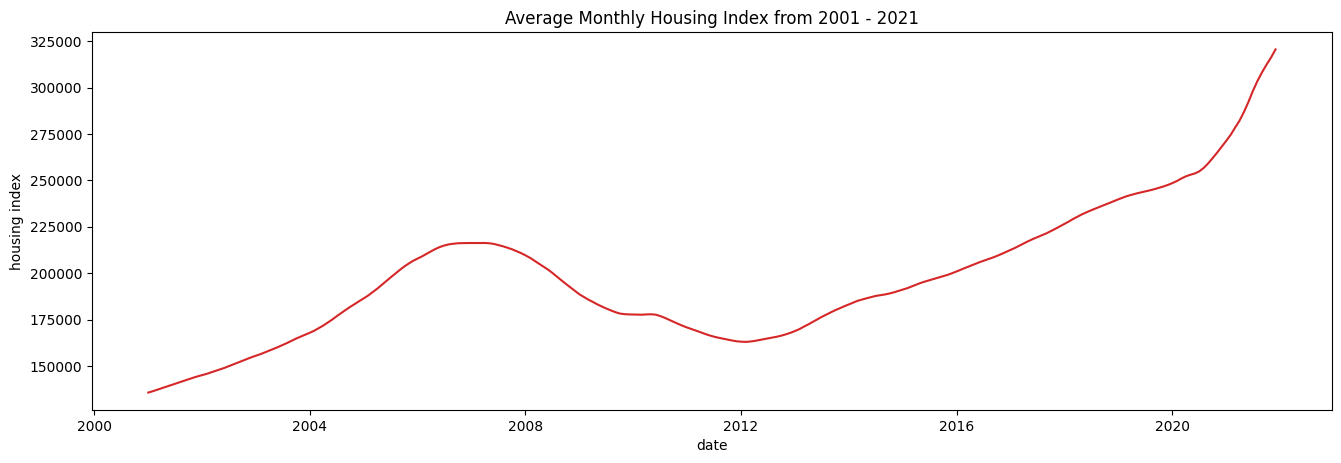

In [159]:
# visualization of housing index over 20 years
def plot_housing(data, x, y, title="", xlabel='date', ylabel='housing index', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_housing(data, x=data.datetime, y=data.avg_us_housing, title='Average Monthly Housing Index from 2001 - 2021') 

In [160]:
# isolating data to when covid reporting began
data_covid = data[data['total_cases'] != 0]

In [161]:
# checking how many observations are in the dataset with reported covid data
len(data_covid)

23

The dataset containing reposted covid data only has 23 observations in it. This is going to affect the accuracy of our results since we can't assume normality with obs < 30.

Text(0.5, 1.0, 'Linear Relationship between cases and housing index')

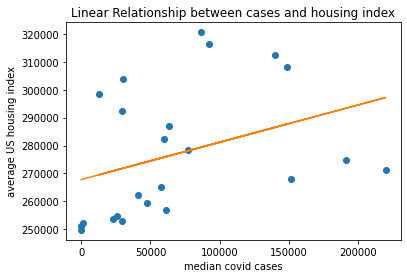

In [162]:
# scatterplot with linear regression line for relationship 
import numpy as np
y=data_covid['avg_us_housing']
x=data_covid['median_new_cases']

plt.plot(x, y, 'o')
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b)

plt.xlabel('median covid cases')
plt.ylabel('average US housing index')
plt.title('Linear Relationship between cases and housing index')

In [163]:
# correlation between average housing index and median new cases for dataset data_covid
y = data_covid['avg_us_housing']
x = data_covid['median_new_cases']
stats.pearsonr(x,y)

(0.35361980435555534, 0.09786171920907842)

With a significance level of aplha=0.05, this test results in no correlation (we also had a small sample size).

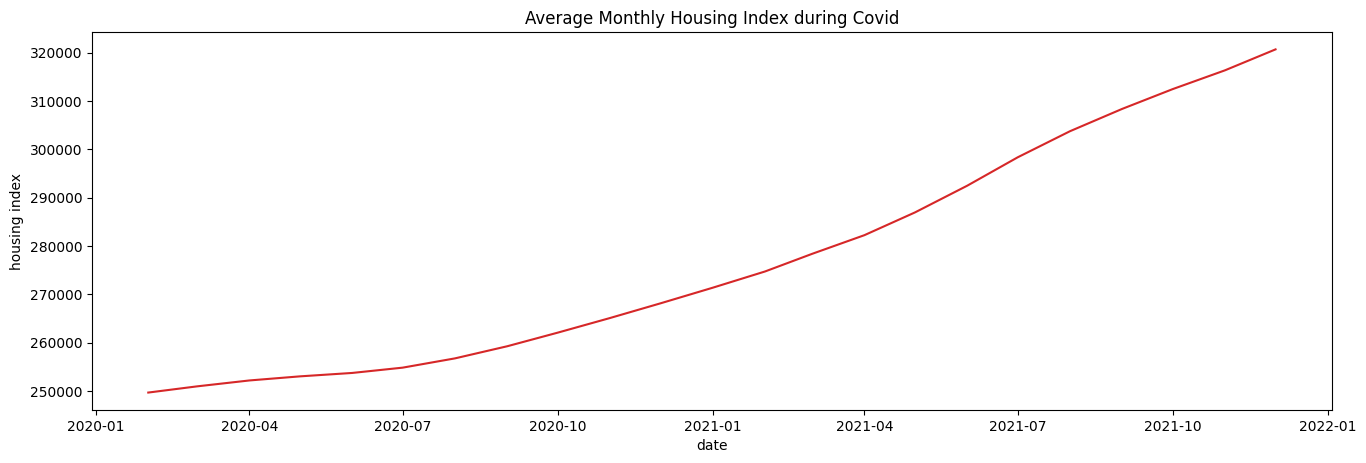

In [164]:
# visualization of housing index in the timeframe where covid data is available
def plot_data(data_covid, x, y, title="", xlabel='date', ylabel='housing index', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_data(data_covid, x=data_covid.datetime, y=data_covid.avg_us_housing, title='Average Monthly Housing Index during Covid')

For the rate over time considering only the housing variable, I would like to perform a time series analysis. This will be completed in the near future, as I am crafting an analysis plan to proceed.